# UJM - Master DSC/MLDM - Deep Learning - TP1b - Images

## Objectives

In this practical session, we will deal with images and try to reproduce results on the famous MNIST Dataset

### Part 1 - MNIST basic

Getting MNIST

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow
tensorflow.random.set_seed(42)

import keras
import time


from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('train data:\t', X_train.shape, y_train.shape)
print('test data:\t', X_test.shape, y_test.shape)

train data:	 (60000, 28, 28) (60000,)
test data:	 (10000, 28, 28) (10000,)


**Note** MNIST contains handwriting data of 10 numbers; each image has size 28 * 28. We display some examples below

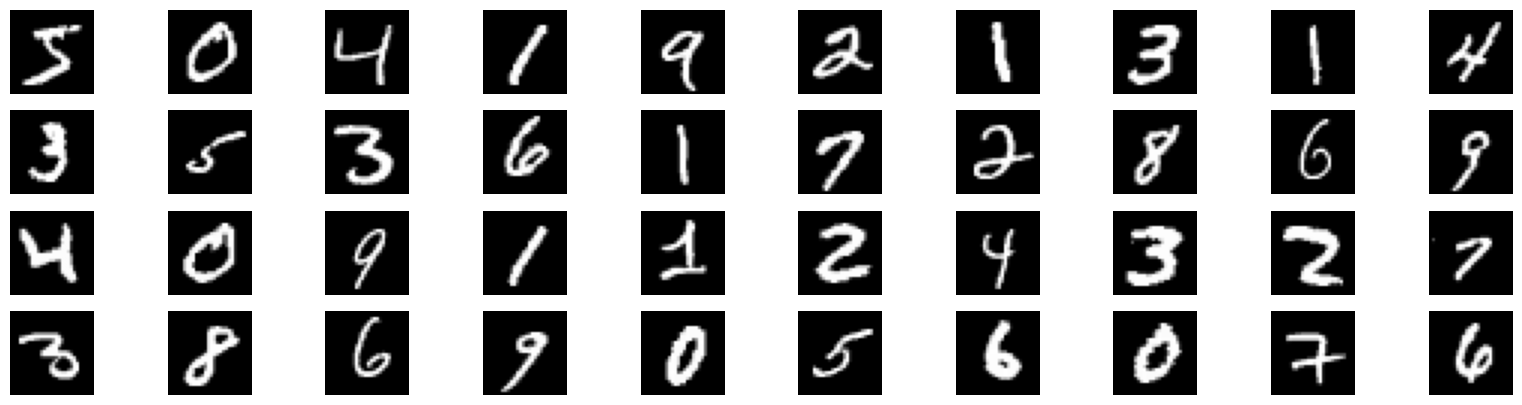

labels:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4, 10, i+1)
    example = X_train[i].reshape((28, 28))
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', y_train[:40])

**Note** We get keras modules and prepare data such that:
- normalize the data (so that the input $\in$ [0,1])
- reshape the input data so that:
- with `X_train` inputs are images: 28 x 28  matrices, adapted for convolutional NN,
- with `x_train` inputs are vectors of size 784, adapted for fully connected NN.  
- check the size of the inputs.

In [3]:
X_train = X_train/255
X_test = X_test/255

x_train = X_train.reshape(60000, 784)  # reshape input from (28,28) to 784
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(np.shape(X_train))
print(np.shape(x_train))

(60000, 28, 28)
(60000, 784)


We display 2 images

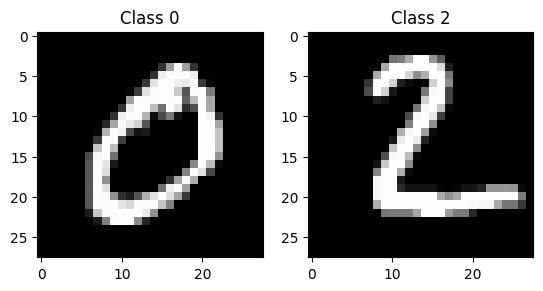

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(60000, 784), dtype=float32)

In [4]:
plt.subplot(1,2,1)
plt.imshow(X_train[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[1]))
plt.subplot(1,2,2)
plt.imshow(X_test[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_test[1]))
plt.show()

x_train.view()

**Note**
Data preprocessing: the output
-Now let's recode the output using a complete disjunctive coding in `Y_Train`. We have two ways of coding the outputs:
 - y_train a vector of 60 000 digits $\in$ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
 - Y_Train a binary matrix of size 60 000 by 10

As in previous session, we take the second solution

In [5]:
num_classes = 10;
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

Y_train.view()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(60000, 10))

## Let's start with fully connected neural networks (NN)
They are also called multi layered perceptrons (MLP).

In that case, the sequential model of keras is used mainly because its more simple (for a discusion on the two keras modes see for instance https://jovianlin.io/keras-models-sequential-vs-functional/).

MLP have fully connected layers called `Dense` in Keras (https://keras.io/layers/core/).

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Input

### First try
Let's try to reproduce LeCun et al. 1998 reslts available on the [MNIST web site](http://yann.lecun.com/exdb/mnist/). With a 2-layer NN with 300 hidden units, the reported error rate is  4.7%.
We begin with creating the architecture of the NN.
- in that case the neural network is fully conected: the NN is sequential,
- the first layer contained 300 neurons with `tanh` as an activation function,
- the output layer contain 10 neurones (one per class) and the activation function is the `softmax`.

In [7]:
NN = Sequential()
NN.add(Input(shape=(784,)))
NN.add(Dense(units=300, activation='tanh'))
NN.add(Dense(units=10, activation='softmax'))
NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,510 (931.68 KB)

 Trainable params: 238,510 (931.68 KB)

 Non-trainable params: 0 (0.00 B)

**Next step**
Now we are going to train the NN.  
The first step here is to define the cost funtion (the loss) and the learning algorithm.
A natural choice for the loss is the `categorical_crossentropy` well suited for multiclass classification.
As a learning algorithm, let's began with the simple stochastic gradient descent optimizer, with default parameter initialization (that is a learning rate set at $0.01$).   
The second step consist in fitting the NN to the data.
By setting the `verbose` parameter to 0 (no outputs during training), the computing time is significantly reduced.
This training phase may take about one minute.

In [8]:
NN.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(),
           metrics   = ['accuracy'])
t0=time.time()
NN.fit(x_train, Y_train, epochs=10, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))


total computing time: 11.684770107269287


**Next** The quality of this NN is determined by measuring its error rate on the test set.

In [9]:
score = NN.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9381 - loss: 0.2120
Test loss: 0.212 
Test err:  6.19 %


**Question** Try to retrain the same model but by replacing the 'tanh' activation by a 'relu' activation, what happens?

In [10]:
NN2 = Sequential()
NN2.add(Input(shape=(784,)))
NN2.add(Dense(units=300, activation='relu'))
NN2.add(Dense(units=10, activation='softmax'))
NN2.summary()

NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(),
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(x_train, Y_train, epochs=10, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN2.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,510 (931.68 KB)

 Trainable params: 238,510 (931.68 KB)

 Non-trainable params: 0 (0.00 B)


total computing time: 11.520504713058472
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.9568 - loss: 0.1520
Test loss: 0.152 
Test err:  4.32 %


### Second try
Ok, let's improve our training a little bit by introduicing some punch in our optimizer.
To do so we add a momentum term (`momentum=0.9`) and some L2 penalty (`decay=1e-6`). This is done by  replacing the instruction `optimizer=keras.optimizers.SGD(),`  by  `optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), `
 and resume training in the same way as we just did (it may take about one minute).

 If you are using a new version of keras, the argument decay has been deprecated. To simulate the behavior of decay, we need to stablish a learning schedule.

In [11]:
import tensorflow as tf
initial_learning_rate = 0.01
old_decay = 1e-6
steps_per_epoch = 60000 // 32  # 1875 steps per epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=1 - old_decay,
    staircase=False
)

In [12]:
NN1 = Sequential()
NN1.add(Input(shape=(784,)))
NN1.add(Dense(units=300, activation='tanh'))
NN1.add(Dense(units=10, activation='softmax'))
NN1.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),
            metrics=['accuracy'])

**Next** We evaluate

In [13]:
t0=time.time()
NN1.fit(x_train, Y_train, epochs=10, verbose=1) # The batch_size argument for the fit method is 32 by default
print('')
print('total computing time: '+str(time.time()-t0))

score = NN1.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 12.514056921005249
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.9759 - loss: 0.0725
Test loss: 0.072 
Test err:  2.41 %


### Third try

Let's try the same architecture with another optimizer.
Try the `Adadelta` optimizer with default parameters(it may take about one minute).  
To do so, replace the instruction  `optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),` by  `optimizer=keras.optimizers.Adadelta(), `

We retrain the model and evaluate

In [14]:
NN2 = Sequential()
NN2.add(Input(shape=(784,)))
NN2.add(Dense(units=300, activation='tanh'))
NN2.add(Dense(units=10, activation='softmax'))
NN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
t0=time.time()
NN2.fit(x_train, Y_train, epochs=20, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN2.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 35.328272104263306
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.8811 - loss: 0.4844
Test loss: 0.484 
Test err:  11.89 %


### Fourth try

In the MNIST leaderboad, with a 3-layer NN, 500+300 HU, softmax, cross entropy, weight decay, Hinton, reproted in 2005 an error rate of 1.53%. For fun we can use a ReLU activation function. The training phase takes about 5 minutes.

We retrain and evaluate

In [ ]:
NN3 = Sequential()
NN3.add(Input(shape=(784,)))
NN3.add(Dense(units=500, activation='relu'))
NN3.add(Dense(units=300, activation='tanh'))
NN3.add(Dense(units=10, activation='softmax'))

NN3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

NN3.summary()

t0=time.time()
NN3.fit(x_train, Y_train, epochs=20, verbose=1,batch_size=64)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN3.evaluate(x_test, Y_test, verbose=1)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,810 (2.08 MB)

 Trainable params: 545,810 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


total computing time: 38.198176860809326
Test loss: 0.101 
Test err:  1.88 %


## Let's continue with Convolutional neural networks (CNN)

In the MNIST leaderboad, LeCun et al. 1998 reported with LeNet-5 an error rate of 0.95%.
LeNet-5 is a convolutional neural network.

<img src="https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-11.34.51-AM.png" alt="MNIST data" width="360" height="270" border="5" />

Convolution used to process images are 2d convolutions taking tensors as input and output.
To fit into the first 2d convolutional layer, the input have to be recast as tensor of dimension $28 \times 28 \times 1$. This can be performed by using a reshape.

In [16]:
img_rows, img_cols = 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(60000, 28, 28, 1)

## First try with CNN
With a simplified version of LeNet-5 and with ReLU instead of hyperbolic tangent as activation function. It takes about 3 minutes.


In [17]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

CNN = Sequential()
CNN.add(Input(shape=(28,28,1)))
CNN.add(Conv2D(6, kernel_size=(5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(16, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
CNN.add(Dense(120, activation='relu'))
CNN.add(Dense(84, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 43.97232007980347
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.9870 - loss: 0.0627
Test loss: 0.063 
Test err:  1.30 %


## Second try
With a CNN slightly more complex

In [ ]:
CNN = Sequential()
CNN.add(Input(shape=(28,28,1)))
CNN.add(Conv2D(32, kernel_size=(5, 5),
           activation='relu'))
CNN.add(Conv2D(64, (3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))
CNN.add(Flatten())
CNN.add(Dense(128, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(10, activation='softmax'))
CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
CNN.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,978 (3.86 MB)

 Trainable params: 1,011,978 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

**Next** we proceed to the training in the same way, using `Adam` as optimizer. It may take about 15 minutes.

In [19]:
t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 277.60887598991394
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9933 - loss: 0.0259
Test loss: 0.026 
Test err:  0.67 %


**Question** Can you improve these results by using other activation functions (e.g. 'relu')?

It already uses relu?

**Question** Can you improve the results above with more complex architectures?

In [24]:
from keras.layers import BatchNormalization
from keras.optimizers import Adam

CNN1 = Sequential()

CNN1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
CNN1.add(BatchNormalization())
CNN1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
CNN1.add(Dropout(0.25))

CNN1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
CNN1.add(Dropout(0.25))

CNN1.add(Flatten())
CNN1.add(Dense(512, activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(Dropout(0.25))
CNN1.add(Dense(1024, activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(Dropout(0.5))
CNN1.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

CNN1.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer,metrics=['accuracy'])
CNN1.summary()

t0=time.time()
CNN1.fit(X_train, Y_train, epochs=5, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN1.evaluate(X_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9456 - loss: 0.1951
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9747 - loss: 0.0917
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.9799 - loss: 0.0734
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.9829 - loss: 0.0609
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 87s 46ms/step - accuracy: 0.9848 - loss: 0.0518

total computing time: 394.73080492019653
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9896 - loss: 0.0408
Test loss: 0.041 
Test err:  1.04 %


# Part 3 Other dataset

try to do your best with another version of this dataset: fashion_MNIST

train data:	 (60000, 28, 28) (60000,)
test data:	 (10000, 28, 28) (10000,)


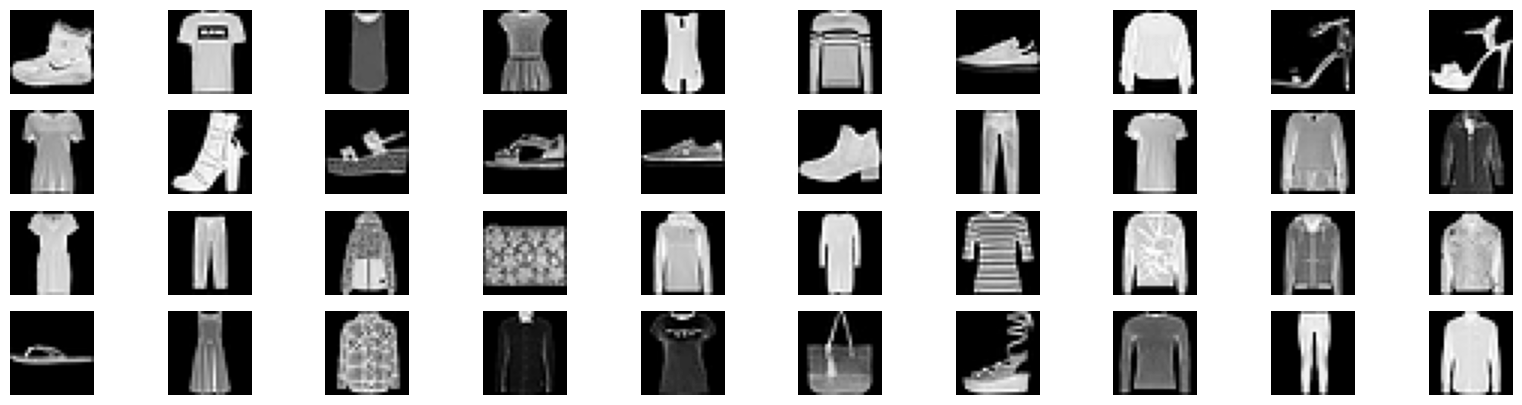

labels:  [9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6]


In [25]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print('train data:\t', X_train.shape, y_train.shape)
print('test data:\t', X_test.shape, y_test.shape)

plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4, 10, i+1)
    example = X_train[i].reshape((28, 28))
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', y_train[:40])

**Note** Try classic MLP and convolutional Neural Networks of different complexities, different regularizers, ...


In [32]:
# normalize
X_train = X_train/255
X_test = X_test/255

X_train_cnn = X_train
X_test_cnn = X_test

# reshape for mlp
X_train_mlp = X_train.reshape(60000, 784).astype('float32')
X_test_mlp = X_test.reshape(10000, 784).astype('float32')

print(np.shape(X_train_mlp))
print(np.shape(X_train))

(60000, 784)
(60000, 28, 28)


In [29]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train.view()

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(60000, 10))

### Classic MLP

In [ ]:
mlp = Sequential()
mlp.add(Input(shape=(784,)))
mlp.add(Dense(units=500, activation='relu'))
mlp.add(Dense(units=300, activation='tanh'))
mlp.add(Dense(units=10, activation='softmax'))

mlp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mlp.summary()

t0=time.time()
mlp.fit(X_train_mlp, y_train, epochs=20, verbose=1,batch_size=64)
print('')
print('total computing time: '+str(time.time()-t0))

score = mlp.evaluate(X_test_mlp, y_test, verbose=1)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,810 (2.08 MB)

 Trainable params: 545,810 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7297 - loss: 0.7369
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8270 - loss: 0.4832
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8460 - loss: 0.4263
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8574 - loss: 0.3948
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8652 - loss: 0.3717
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8714 - loss: 0.3531
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8772 - loss: 0.3376
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8817 - loss: 0.3244
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8857 - loss: 0.3125
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8892 - loss: 0.3022
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8930 - loss: 0.2924
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

### CNN

In [34]:
from keras.layers import BatchNormalization
from keras.optimizers import Adam

CNN1 = Sequential()

CNN1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
CNN1.add(BatchNormalization())
CNN1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
CNN1.add(Dropout(0.25))

CNN1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
CNN1.add(Dropout(0.25))

CNN1.add(Flatten())
CNN1.add(Dense(512, activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(Dropout(0.25))
CNN1.add(Dense(1024, activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(Dropout(0.5))
CNN1.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

CNN1.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer,metrics=['accuracy'])
CNN1.summary()

t0=time.time()
CNN1.fit(X_train_cnn, y_train, epochs=5, verbose=1)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN1.evaluate(X_test_cnn, y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


/Users/buudinhha/PycharmProjects/deep-learning-2/DL_TP1/keras/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.7485 - loss: 0.7528
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - accuracy: 0.8503 - loss: 0.4208
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.8696 - loss: 0.3629
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.8820 - loss: 0.3237
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.8928 - loss: 0.2960

total computing time: 365.67256689071655
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2656 - loss: 9.5897
Test loss: 9.590 
Test err:  73.44 %


**Note** you could compare your results with:  <https://www.kaggle.com/pavansanagapati/fashion-mnist-cnn-model-with-tensorflow-keras>

**Final Question** Write down the similarities and differences between torch and keras version of the notebooks below.


### Similarities
- We follow the same overall structure, model architecture, training config
### Differences
- Data preprocessing: keras - manual normalization, pytorch - normalization handled by ToTensor()
- Model definition: diffrent syntax, no explicit softmax when defining model for pytorch since CrossEntropyLoss includes it
- Training: keras - high-level API: compile then fit, pytorch - manual implemenation
- Evaluation: keras - high-level API: evaluate to get score, pytorch - manual implemenation